In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Dense, Activation, Flatten, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import SGD

## Load the data 

In [2]:
columns = ["text","label"]
train = pd.read_csv("/Users/k/Downloads/ultimateai_ml_engineer_challenge/data/atis/train.tsv", sep="\t", names=columns)
test = pd.read_csv("/Users/k/Downloads/ultimateai_ml_engineer_challenge/data/atis/test.tsv", sep="\t", names=columns)

### Combine both train and test data to make sure working on the same number of classes.

In [3]:
combined = pd.concat([train, test])
combined = combined.sample(frac=1).reset_index(drop=True)

In [4]:
len(combined['label'].unique())

26

### Convert the labels into one-hot encoded form

In [5]:
one_hot = pd.get_dummies(combined['label'])
# Drop column 'label' as it is now encoded
df = combined.drop('label',axis = 1)
# Join the encoded df
df = df.join(one_hot)
df  

,text,abbreviation,aircraft,aircraft+flight+flight_no,airfare,airfare+flight,airfare+flight_time,airline,airline+flight_no,airport,...,flight+airline,flight_no,flight_no+airline,flight_time,ground_fare,ground_service,ground_service+ground_fare,meal,quantity,restriction
0,i 'd like a morning flight from newark to los ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,give me the flights from chicago to seattle sa...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,how much is the 718 am flight from las vegas t...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,what is the latest us air flight leaving phila...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,please list all flights from new york to miami...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5479,first flights and fares from pittsburgh to atl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5480,what are all flights from san francisco to phi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5481,find a nonstop flight between boston and washi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5482,show me the flight schedule from pittsburgh to...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Get x and y from the data

In [6]:
X_train = df["text"].values

In [7]:
i,j = df.shape
pos = [col+1 for col in range(j-1)]
y_train = df[df.columns[[pos]]].values

/Users/k/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [23]:
classes = df.columns[[pos]]

Index(['abbreviation', 'aircraft', 'aircraft+flight+flight_no', 'airfare',
       'airfare+flight', 'airfare+flight_time', 'airline', 'airline+flight_no',
       'airport', 'capacity', 'cheapest', 'city', 'day_name', 'distance',
       'flight', 'flight+airfare', 'flight+airline', 'flight_no',
       'flight_no+airline', 'flight_time', 'ground_fare', 'ground_service',
       'ground_service+ground_fare', 'meal', 'quantity', 'restriction'],
      dtype='object')

In [8]:
X_train.shape, y_train.shape

((5484,), (5484, 26))

In [9]:
X_train[1], y_train[1] 

('give me the flights from chicago to seattle saturday morning that have meals',
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=uint8))

## Preprocessing
Tokenize the X_train (the text).This means breaking the sentences into individuals and convert these individuals into numerical representations.

In [10]:
text = X_train
# text preprocessing
Tokenizer = Tokenizer()
Tokenizer.fit_on_texts(text) 
Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
Tokenizer_vocab_size, X_train.shape, y_train.shape

(942, (5484,), (5484, 26))

In [11]:
samples = 1646 # 30% 

X_train = X_train[samples:] 
y_train = y_train[samples:] 

X_val = X_train[:samples] 
y_val = y_train[:samples] 

X_train_encoded_words = Tokenizer.texts_to_sequences(X_train)
X_val_encoded_words = Tokenizer.texts_to_sequences(X_val)
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen = 4000)
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen = 4000)

X_train_encoded_padded_words.shape, X_val_encoded_padded_words.shape

((3838, 4000), (1646, 4000))

In [12]:
X_val_encoded_padded_words, X_train_encoded_padded_words

(array([[  0,   0,   0, ...,  50,  53,  18],
        [  0,   0,   0, ...,  18,   1,  12],
        [  0,   0,   0, ..., 209, 100, 131],
        ...,
        [  0,   0,   0, ...,   5, 189, 245],
        [  0,   0,   0, ...,  45, 495,  33],
        [  0,   0,   0, ...,  20,   1,  24]], dtype=int32),
 array([[  0,   0,   0, ...,  50,  53,  18],
        [  0,   0,   0, ...,  18,   1,  12],
        [  0,   0,   0, ..., 209, 100, 131],
        ...,
        [  0,   0,   0, ..., 143, 132,  33],
        [  0,   0,   0, ...,   1,  10,  17],
        [  0,   0,   0, ...,  45, 187,  33]], dtype=int32))

## Build and Train the Model
Use short-term memory (LSTM), which is an artificial recurrent neural network (RNN). 

In [15]:
model = Sequential()

model.add(Embedding(Tokenizer_vocab_size, 32, input_length = 4000)) 

model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(26, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4000, 32)          30144     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 800)               8800      
_________________________________________________________________
dropout_4 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               160200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)              

In [16]:

Nadam = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])

history  = model.fit(X_train_encoded_padded_words,y_train, epochs = 5, batch_size=32, verbose=1, validation_data=(X_val_encoded_padded_words, y_val))

Epoch 1/5
120/120 [==============================] - 196s 2s/step - loss: 1.1486 - accuracy: 0.7418 - val_loss: 0.7325 - val_accuracy: 0.7953
Epoch 2/5
120/120 [==============================] - 192s 2s/step - loss: 0.7299 - accuracy: 0.8090 - val_loss: 0.5486 - val_accuracy: 0.8505
Epoch 3/5
120/120 [==============================] - 192s 2s/step - loss: 0.5946 - accuracy: 0.8421 - val_loss: 0.4294 - val_accuracy: 0.8809
Epoch 4/5
120/120 [==============================] - 191s 2s/step - loss: 0.5404 - accuracy: 0.8570 - val_loss: 0.3779 - val_accuracy: 0.8840
Epoch 5/5
120/120 [==============================] - 192s 2s/step - loss: 0.4531 - accuracy: 0.8742 - val_loss: 0.3592 - val_accuracy: 0.8906


In [17]:
# save the model
model.save("Intent_Classification.h5")

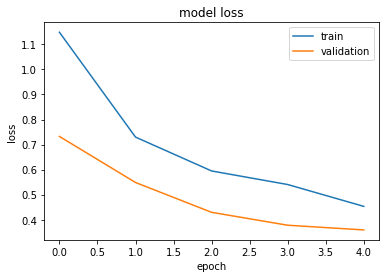

In [18]:

#loss
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

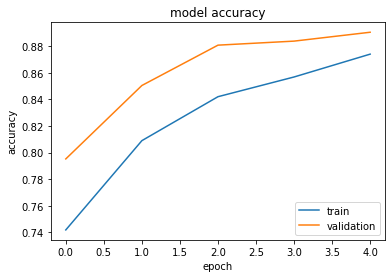

In [19]:

#accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [20]:
model.evaluate(X_val_encoded_padded_words, y_val)

52/52 [==============================] - 8s 157ms/step - loss: 0.3592 - accuracy: 0.8906


[0.3591611683368683, 0.8906440138816833]

In [25]:
sentence = "find me a flight that flies from memphis to tacoma"
tokens = Tokenizer.texts_to_sequences([sentence])
tokens = pad_sequences(tokens, maxlen = 6000)
prediction = model.predict(np.array(tokens))
pred = np.argmax(prediction)
classes[pred]

'flight'